In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import tensorflow_datasets as tfds

In [2]:
print(f'Tensorflow Version: {tf.__version__}')
print(f'TFDS Version: {tfds.__version__}')
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

tf.keras.backend.clear_session()  # For easy reset of notebook state.

Tensorflow Version: 2.1.0
TFDS Version: 2.1.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tf.executing_eagerly()

True

In [4]:
train, info = tfds.load('imagenette', split="train", with_info=True)
validation = tfds.load('imagenette', split="validation")

In [5]:
info

tfds.core.DatasetInfo(
    name='imagenette',
    version=0.1.0,
    description='Imagenette is a subset of 10 easily classified classes from the Imagenet
dataset. It was originally prepared by Jeremy Howard of FastAI. The objective
behind putting together a small version of the Imagenet dataset was mainly
because running new ideas/algorithms/experiments on the whole Imagenet take a
lot of time.

This version of the dataset allows researchers/practitioners to quickly try out
ideas and share with others. The dataset comes in three variants:

  * Full size
  * 320 px
  * 160 px

Note: The v2 config correspond to the new 70/30 train/valid split (released
in Dec 6 2019).',
    homepage='https://github.com/fastai/imagenette',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=13394,
    splits={
        'train': 9469,
        'validation': 3925,
    }

In [6]:
# data comes in tuples with a 28x28x1 array of uint8 for the images and 1 uint64 label
train.take(1)

<TakeDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [7]:
ex = info.features['label']

In [8]:
ex.names

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [9]:
#take a look at classes; we can use built in functions for tensors
int2str = {class_int:info.features['label'].int2str(class_int) for class_int in range(info.features['label'].num_classes)}
int2str

{0: 'n01440764',
 1: 'n02102040',
 2: 'n02979186',
 3: 'n03000684',
 4: 'n03028079',
 5: 'n03394916',
 6: 'n03417042',
 7: 'n03425413',
 8: 'n03445777',
 9: 'n03888257'}

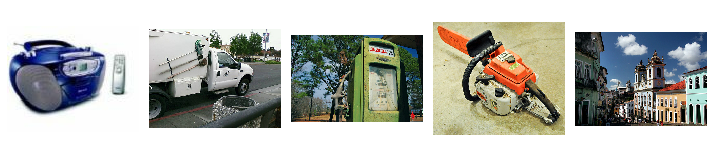

In [10]:
def plot_images(ds=train, n=5):
    """Plot n samples of images"""
    examples = ds.take(n)
    # 28x28 to visualize (dont need the color channel)
    
    imgs = [x['image'].numpy() for x in examples]
    # use our int2str to get string of int labels
    labels = [int2str[x['label'].numpy()] for x in examples]
    
    fig, axes = plt.subplots(1, len(imgs), figsize=(10,10))
    axes = axes.flatten()
    for img, ax, label in zip(imgs, axes, labels):
        ax.imshow(img)
        ax.set_title(label, color='w')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_images()

In [11]:
def preprocess(features):
    """Preprocess an image"""
    #includes the label to make things easier
    img = features['image']
    img = tf.cast(img, dtype=tf.float32)
    #img = tf.image.per_image_standardization(img) #normalize the image pixel values for that image (generally preferred to whole dataset)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0
    return img, features['label']

In [12]:
for ex in train.take(1):
    x, _ = preprocess(ex)
    x = x.numpy()
    assert x.shape == (224, 224, 3), "Array not of the right shape"
    assert (x >= -4).all() and (x <= 4).all(), "Weights weren't normalized"
    
#     plt.figure(figsize=(10,10))
#     plt.imshow(x)
#     plt.show()

In [13]:
train = train.map(preprocess).shuffle(1000).batch(32) #batch size 256 in the paper

In [14]:
class VGG16(tf.keras.Model):
    def __init__(self):
        super(VGG16, self).__init__()        
        
        # Block 1
        self.conv1_1 = Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3))
        self.conv1_2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')
        self.max1 = MaxPooling2D(pool_size=(2, 2), strides=2)
        
        # Block 2
        self.conv2_1 = Conv2D(128, kernel_size=3, padding='same', activation='relu')
        self.conv2_2 = Conv2D(128, kernel_size=3, padding='same', activation='relu')
        self.max2 = MaxPooling2D(pool_size=(2, 2), strides=2)

        # Block 3
        self.conv3_1 = Conv2D(256, kernel_size=3, padding='same', activation='relu')
        self.conv3_2 = Conv2D(256, kernel_size=3, padding='same', activation='relu')
        self.conv3_3 = Conv2D(256, kernel_size=3, padding='same', activation='relu')
        self.max3 = MaxPooling2D(pool_size=(2, 2), strides=2)

        # Block 4
        self.conv4_1 = Conv2D(512, kernel_size=3, padding='same', activation='relu')
        self.conv4_2 = Conv2D(512, kernel_size=3, padding='same', activation='relu')
        self.conv4_3 = Conv2D(512, kernel_size=3, padding='same', activation='relu')
        self.max4 = MaxPooling2D(pool_size=(2, 2), strides=2)

        self.conv5_1 = Conv2D(512, kernel_size=3, padding='same', activation='relu')
        self.conv5_2 = Conv2D(512, kernel_size=3, padding='same', activation='relu')
        self.conv5_3 = Conv2D(512, kernel_size=3, padding='same', activation='relu')
        self.max5 = MaxPooling2D(pool_size=(2, 2), strides=2)

        self.flat = Flatten()
        self.dense1 = Dense(4096, activation='relu')
        self.drop1 = Dropout(0.5)
        self.dense2 = Dense(4096, activation='relu')
        self.drop2 = Dropout(0.5)
        self.out = Dense(10, activation='softmax')
        
    def call(self, inputs):
        #inputs = tf.keras.Input(tensor=inputs)
        x = self.conv1_1(inputs)
        x = self.conv1_2(x)
        x = self.max1(x)
        
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.max2(x)
        
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.max3(x)
        
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.max4(x)
        
        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)
        x = self.max5(x)
        
        x = self.flat(x)
        x = self.dense1(x)
        x = self.drop1(x)
        x = self.dense2(x)
        x = self.drop2(x)
        outputs = self.out(x)
        return outputs

In [15]:
vgg16 = VGG16()
#vgg16.build(input_shape=[224, 224, 3])
#vgg16.summary()

In [16]:
vgg16.build(input_shape=(32, 224, 224, 3))
vgg16.summary()

Model: "vg_g16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73856     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  29516

In [17]:
vgg16.compile(optimizer=tf.optimizers.SGD(learning_rate=.01, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
vgg16.fit(train, epochs=10)

Epoch 1/10
296/296 [==============================] - 173s 584ms/step - loss: 2.3026 - accuracy: 0.1017
Epoch 2/10
296/296 [==============================] - 170s 573ms/step - loss: 2.3024 - accuracy: 0.1074
Epoch 3/10
296/296 [==============================] - 170s 575ms/step - loss: 2.3023 - accuracy: 0.1086
Epoch 4/10
296/296 [==============================] - 171s 577ms/step - loss: 2.2992 - accuracy: 0.1119
Epoch 5/10
259/296 [=========================>....] - ETA: 21s - loss: 2.3053 - accuracy: 0.1117